# Neural Transfer Learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from imageio import mimsave
from IPython.display import display as display_fn

import tensorflow as tf


### Loading image and preprocessing functions

In [3]:
def load_img(path_to_img):
    '''loads an image as a tensor and scales it to 512 pixels'''
    max_dim = 512
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    shape = tf.shape(image)[:-1]
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return image


In [4]:
def tensor_to_image(tensor):
    '''converts a tensor to an image'''
    tensor_shape = tf.shape(tensor)
    number_elem_shape = tf.shape(tensor_shape)
    if number_elem_shape > 3:
        assert tensor_shape[0] == 1
        tensor = tensor[0]
    return tf.keras.preprocessing.image.array_to_img(tensor) 


In [5]:
load_img('content.jpeg')

<tf.Tensor: shape=(1, 288, 512, 3), dtype=uint8, numpy=
array([[[[186, 213, 234],
         [186, 213, 234],
         [184, 211, 233],
         ...,
         [170, 198, 218],
         [171, 195, 216],
         [199, 212, 222]],

        [[184, 211, 232],
         [184, 211, 232],
         [182, 209, 230],
         ...,
         [169, 196, 215],
         [170, 194, 214],
         [197, 211, 220]],

        [[184, 211, 232],
         [182, 209, 230],
         [182, 209, 230],
         ...,
         [169, 194, 213],
         [168, 192, 211],
         [197, 212, 219]],

        ...,

        [[171, 153, 115],
         [171, 153, 115],
         [172, 154, 116],
         ...,
         [168, 150, 126],
         [166, 150, 126],
         [188, 181, 163]],

        [[171, 153, 115],
         [171, 153, 115],
         [171, 153, 115],
         ...,
         [167, 149, 125],
         [164, 147, 124],
         [187, 181, 164]],

        [[168, 153, 114],
         [168, 153, 114],
         [168, 153

In [6]:
def imshow(image, title=None):
    '''displays an image with a corresponding title'''
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        print(image.shape)
    plt.imshow(image)
    if title:
        plt.title(title)

(288, 512, 3)


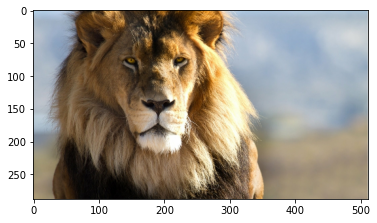

In [7]:
imshow(load_img('content.jpeg'))

In [8]:
def preprocess_image(image):
    '''centers the pixel values of a given image to use with VGG-19'''
    image = tf.cast(image, dtype=tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(288, 512, 3)


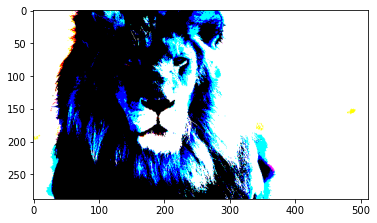

In [9]:
imshow(preprocess_image(load_img('content.jpeg')))

In [10]:
def show_images_with_objects(images, titles=[]):
    '''displays a row of images with corresponding titles'''
    if len(images) != len(titles):
        return 'here'

    plt.figure(figsize=(20, 12))
    for idx, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(2, len(images), idx + 1)
        plt.xticks([])
        plt.yticks([])
        imshow(image, title)
        
        plt.subplot(2, len(images), idx + 3)
        plt.xticks([])
        plt.yticks([])
        imshow(preprocess_image(image), ' preprocessed '+title)

        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(288, 512, 3)
(288, 512, 3)
(412, 512, 3)
(412, 512, 3)


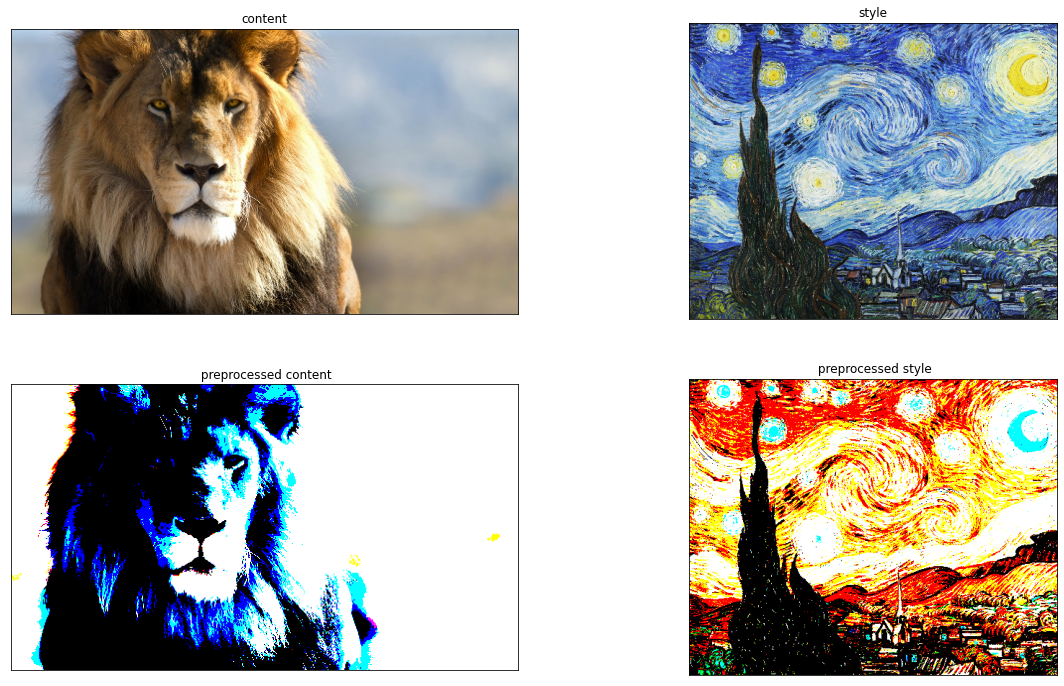

In [11]:
show_images_with_objects( (load_img('content.jpeg'), load_img('Vann_style.jpg') ) ,titles = ['content' , 'style'])

## Model VGG-19 to get activations from different layers 
    In order to get content of the image we get activation from latest layer. From last block
    However, it will be first convolution layer of the each block for getting the style of the image

<img src="model.png" style="width:700px;height:400;">

In [18]:
# download the vgg19 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
#layers that will give us insight about style of the image
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]

# layer that will help us to maintain
content_layers = ['block5_conv2']

output_layers = style_layers + content_layers 

NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

### Getting needed layer outputs from the model

In [21]:
def vgg_model(layer_names):

      # load the the pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

      # freeze the weights of the model's layers (make them not trainable)
    vgg.trainable = False

      # create a list of layer objects that are specified by layer_names
    outputs = [vgg.get_layer(name).output for name in layer_names]

      # create the model that outputs content and style layers only
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

    return model

In [22]:
vgg = vgg_model(output_layers)
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [23]:
def gram_matrix(input_tensor):

      # calculate the gram matrix of the input tensor
    gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

      # get the height and width of the input tensor
    input_shape = tf.shape(input_tensor) 
    height = input_shape[1] 
    width = input_shape[2] 

      # get the number of locations (height times width), and cast it as a tf.float32
    num_locations = tf.cast(height * width, tf.float32)

      # scale the gram matrix by dividing by the number of locations
    scaled_gram = gram / num_locations

    return scaled_gram

In [24]:
def get_style_image_features(image):  
    
    # preprocess the image using the given preprocessing function
    preprocessed_style_image = preprocess_image(image) 
    
    # get the outputs from the custom vgg model that you created using vgg_model()
    outputs = vgg(preprocessed_style_image) 
    
    # Get just the style feature layers (exclude the content layer)
    
    style_outputs = outputs[:NUM_STYLE_LAYERS] 
    
    # for each style layer, calculate the gram matrix for that layer and store these results in a list
    gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 
    
    return gram_style_features
  

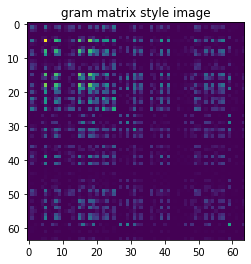

In [25]:
imshow(tf.reshape(get_style_image_features(load_img('style.jpg'))[0], (64,64)),title = 'gram matrix style image')


In [28]:
def get_content_image_features(image):
    
    preprocessed_content_image = preprocess_image(image)
    
    outputs = vgg(preprocessed_content_image)
    
    content_feature_map = outputs[NUM_STYLE_LAYERS:]
    
    return content_feature_map

In [31]:
tmp_layer_list = [layer.output for layer in vgg.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (cr

#### Loss functions

In [37]:
def content_loss(features, targets):
    
    content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
    
    return content_loss

In [38]:
def style_loss(features, targets):
    
    style_loss = 0.5 * tf.reduce_mean( tf.square(features - targets))
    
    return style_loss

In [39]:
def get_style_content_loss(content_features, content_targets, content_weight,
                           style_features , style_targets , style_weight):
    
    sum_of_content_loss = tf.add_n([content_loss(feature,target) for feature,target in zip(content_features, content_targets)])
    sum_of_content_loss /= NUM_CONTENT_LAYERS
    
    
    sum_of_style_loss = tf.add_n([style_loss(feature,target) for feature,target in zip(style_features, style_targets)])
    sum_of_style_loss/= NUM_STYLE_LAYERS
    
    
    loss = content_weight*sum_of_content_loss + style_weight * sum_of_style_loss
    
    return loss
    
    

### Calculating the gradients of the losses with respect to intial content and style image
    Gradients will be used to incrementally update the content image with the style features

In [40]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):

    with tf.GradientTape() as tape:
        
      # get the style image features
      style_features = get_style_image_features(image) 
        
      # get the content image features
      content_features = get_content_image_features(image) 
        
      # get the style and content loss
      loss = get_style_content_loss(content_features, content_targets, content_weight,
                                     style_features , style_targets , style_weight) 

    # calculate gradients of loss with respect to the image
    gradients = tape.gradient(loss, image) 
    
    return gradients


In [41]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):
  

    # calculate gradients using the function that you just defined.
    gradients = calculate_gradients(image, style_targets, content_targets, 
                                    style_weight, content_weight, var_weight) 
    # apply the gradients to the given image
    optimizer.apply_gradients([(gradients, image)]) 
    # clip the image using the utility clip_image_values() function
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0))



In [51]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
    """ Performs neural style transfer.  
    Returns:
      generated_image: generated image at final epoch
      images: collection of generated images per epoch  
    """

    images = []
    step = 0

    # get the style image features 
    style_targets = get_style_image_features(style_image)
      
    # get the content image features
    content_targets = get_content_image_features(content_image)

    # initialize the generated image for updates
    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image) 
      
    # collect the image updates starting from the content image
    images.append(content_image)
  
    # incrementally update the content image with the style features
    for n in range(epochs):
        
        for m in range(steps_per_epoch):
            step += 1

            # Update the image with the style using the function that you defined
            update_image_with_style(generated_image, style_targets, content_targets, 
                                    style_weight, var_weight, content_weight, optimizer) 

            print(".", end='')

            if (m + 1) % 10 == 0:
                images.append(generated_image)
      
      # display the current stylized image
#         clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)

          # append to the image collection for visualization later
        images.append(generated_image)
        print("Train step: {}".format(step))

    # convert to uint8 (expected dtype for images with pixels in the range [0,255])
    generated_image = tf.cast(generated_image, dtype=tf.uint8)

    return generated_image, images

In [58]:
style_image = load_img('style_Van.jpeg')
content_image = load_img('content.jpeg')

(288, 512, 3)
(288, 512, 3)
(380, 512, 3)
(380, 512, 3)


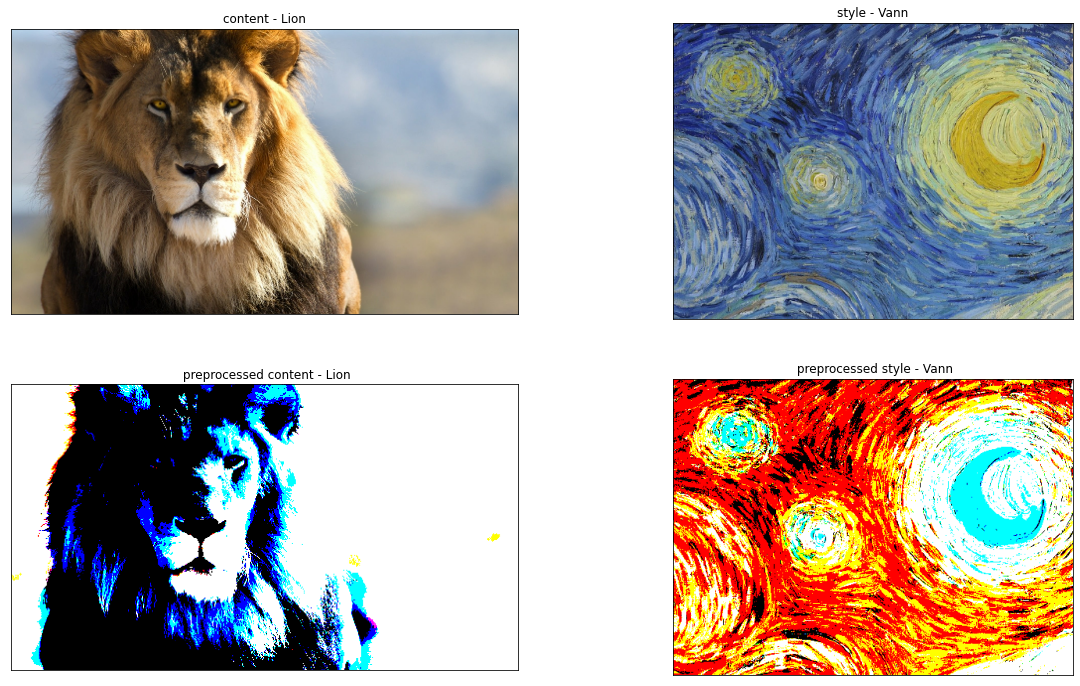

In [59]:
show_images_with_objects( (load_img('content.jpeg'), load_img('style_Van.jpeg') ) ,titles = ['content - Lion' , 'style - Vann'])

## Generating the image

.....

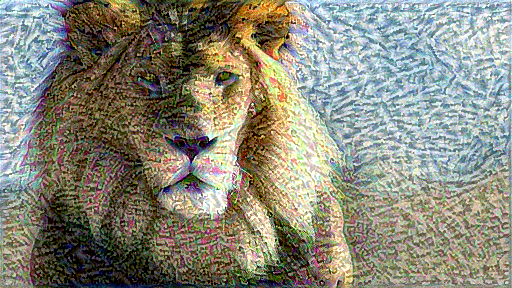

Train step: 5
.....

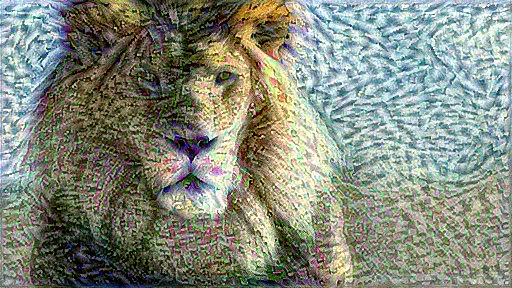

Train step: 10
.....

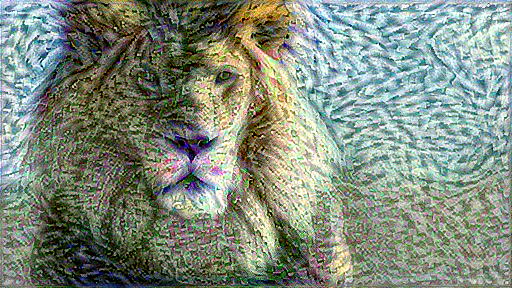

Train step: 15
.....

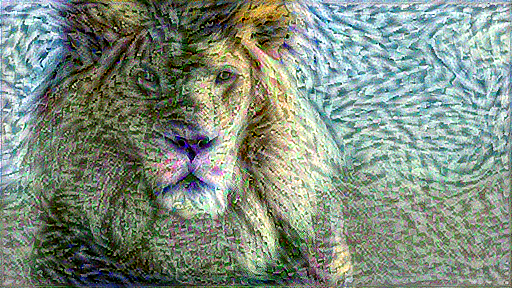

Train step: 20
.....

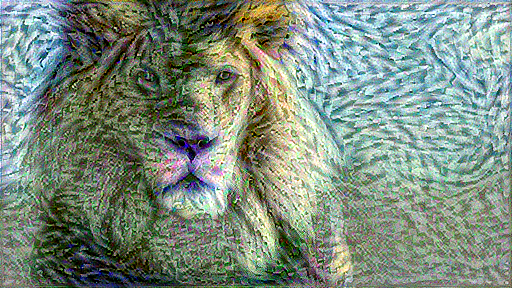

Train step: 25
.....

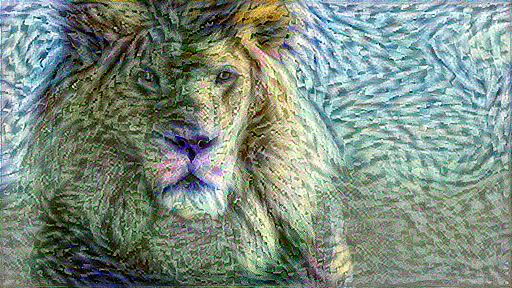

Train step: 30
.....

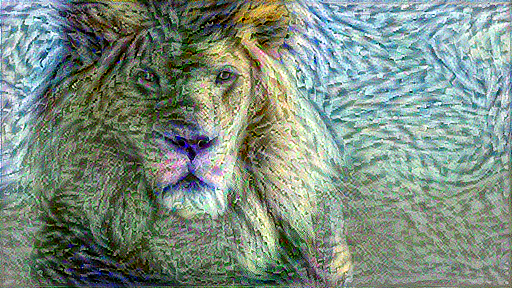

Train step: 35
.....

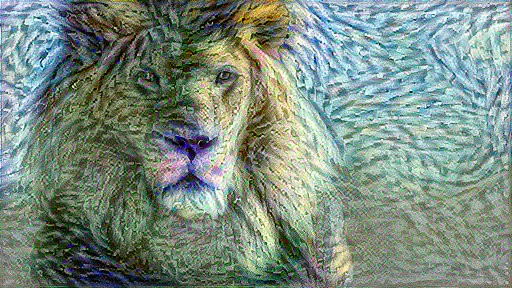

Train step: 40
.....

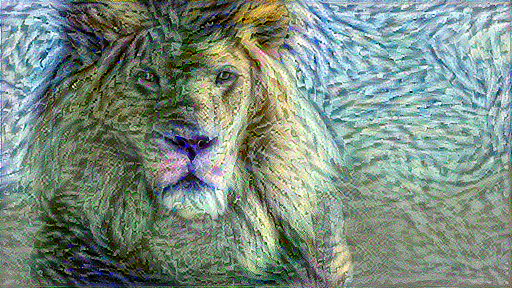

Train step: 45
.....

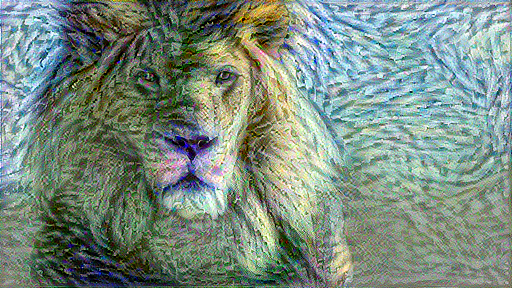

Train step: 50


In [62]:
# define style and content weight
style_weight =  2e-2
content_weight = 1e-2 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=5)